# mobilenetv3

In [1]:
import set_env
from d2py.utils.file import mkdir
root_dir = ".temp"
mkdir(f"{root_dir}/logs")

In [2]:
from PIL import Image
import numpy as np
import torch
from tvm_book.data.augment import LetterBox

In [3]:
imgsz = 256, 192

strides = 8, 16, 32
mean = (0,)
std = (255,)
input_path = "/media/pc/data/board/arria10/lxw/tasks/images/traffic-light-6945091_960_720.jpg"

数据内存的连续性：True
数据内存的连续性(transpose)：False
数据内存的连续性：True


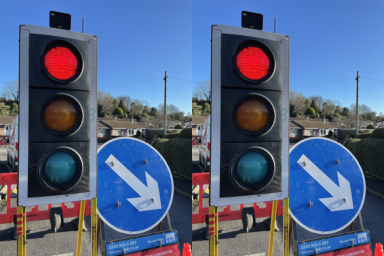

In [4]:
letterbox = LetterBox(imgsz, strides=strides, auto=False)

origin_image = np.asanyarray(Image.open(input_path))
letterbox_image = letterbox(image=origin_image)
xs = np.stack([letterbox_image - mean])
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = xs.transpose((0, 3, 1, 2))  # BHWC to BCHW, (n, 3, h, w)
print(f"数据内存的连续性(transpose)：{xs.flags["C_CONTIGUOUS"]}")
xs = np.ascontiguousarray(xs)  # contiguous
print(f"数据内存的连续性：{xs.flags["C_CONTIGUOUS"]}")
xs = xs.astype("float32") / std # 归一化值域范围为 0.0 - 1.0
Image.fromarray(np.concatenate([letterbox_image, (xs[0]*std).astype("uint8").transpose((1, 2, 0))], axis=1))

In [5]:
import onnx
from tvm import relay

input_name = "images"
onnx_model = onnx.load('/media/pc/data/board/arria10/lxw/tasks/tools/npu_user_demos/models/telecom/Nin1_helmet_small/helmet_small.onnx')
mod, params = relay.frontend.from_onnx(onnx_model, {input_name: xs.shape}, freeze_params=True)

In [6]:
mod.show()

In [8]:
from copy import deepcopy
import tvm
from tvm import relay
from tvm.relay.quantize.quantize import _bind_params

In [11]:
optimize = tvm.transform.Sequential(
    [
        relay.transform.SimplifyInference(),
        relay.transform.FoldConstant(),
        # relay.transform.FoldScaleAxis(),
        relay.transform.CanonicalizeOps(),
        relay.transform.FoldConstant(),
    ]
)

In [12]:
run_mod = deepcopy(mod)
run_mod["main"] = _bind_params(run_mod["main"], params)
with tvm.transform.PassContext(opt_level=3):
    run_mod2 = relay.quantize.prerequisite_optimize(deepcopy(mod), params)
    run_mod = optimize(run_mod)

In [13]:
print(run_mod["main"])

fn (%images: Tensor[(1, 3, 256, 192), float32] /* ty=Tensor[(1, 3, 256, 192), float32] span=/features/features.0/features.0.0/Conv.images:0:0 */) -> Tensor[(1, 9), float32] {
  %0 = nn.conv2d(%images, meta[relay.Constant][0] /* ty=Tensor[(16, 3, 3, 3), float32] span=/features/features.0/features.0.0/Conv.onnx::Conv_460:0:0 */, strides=[2, 2], padding=[1, 1, 1, 1], channels=16, kernel_size=[3, 3]) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.0/Conv:0:0 */;
  %1 = add(%0, meta[relay.Constant][1] /* ty=Tensor[(16, 1, 1), float32] */) /* ty=Tensor[(1, 16, 128, 96), float32] */;
  %2 = multiply(%1, 0.166667f /* ty=float32 span=/features/features.0/features.0.2/HardSigmoid:0:0 */) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.2/HardSigmoid:0:0 */;
  %3 = add(%2, 0.5f /* ty=float32 span=/features/features.0/features.0.2/HardSigmoid:0:0 */) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.2/HardSigmoid:0

In [14]:
print(run_mod2["main"])

fn (%images: Tensor[(1, 3, 256, 192), float32] /* ty=Tensor[(1, 3, 256, 192), float32] span=/features/features.0/features.0.0/Conv.images:0:0 */) -> Tensor[(1, 9), float32] {
  %0 = nn.conv2d(%images, meta[relay.Constant][0] /* ty=Tensor[(16, 3, 3, 3), float32] span=/features/features.0/features.0.0/Conv.onnx::Conv_460:0:0 */, strides=[2, 2], padding=[1, 1, 1, 1], channels=16, kernel_size=[3, 3]) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.0/Conv:0:0 */;
  %1 = add(%0, meta[relay.Constant][1] /* ty=Tensor[(16, 1, 1), float32] */) /* ty=Tensor[(1, 16, 128, 96), float32] */;
  %2 = multiply(%1, 0.166667f /* ty=float32 span=/features/features.0/features.0.2/HardSigmoid:0:0 */) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.2/HardSigmoid:0:0 */;
  %3 = add(%2, 0.5f /* ty=float32 span=/features/features.0/features.0.2/HardSigmoid:0:0 */) /* ty=Tensor[(1, 16, 128, 96), float32] span=/features/features.0/features.0.2/HardSigmoid:0

In [ ]:
import sys
sys.path.extend(["/media/pc/data/board/arria10/lxw/tasks/tools/npu_user_demos/models/telecom_pt/Nin1_helmet_small"])
import mobilenetv3
from tvm.contrib.msc.core.frontend import translate
torch.cuda.empty_cache()
# 模型配置
bn_norm = "BN"
class_num = 9

# 预处理参数
width = 192   # 输入宽度
height = 256  # 输入高度
std = [58.395, 57.120, 57.375]      # 方差
mean = [123.675, 116.280, 103.530]  # 均值

bn_norm = "BN"
class_num = 9
inverted_residual_setting, last_channel = mobilenetv3._mobilenet_v3_conf("Small", {})
model = mobilenetv3.MobileNetV3(bn_norm, inverted_residual_setting, last_channel, class_num)

model_path = "/media/pc/data/board/arria10/lxw/tasks/tools/npu_user_demos/models/telecom_pt/Nin1_helmet_small/helmet_small.pth"
state_dict = torch.load(model_path,map_location=torch.device('cpu'))
model.load_state_dict({k.replace('backbone.','').replace('heads.',''):v for k,v in state_dict['model'].items()}, strict=True)
model.to(torch.device("cpu"))
model = model.eval()
from torch import fx
from tvm.relax.frontend.torch import from_fx
input_info = [(xs.shape, "float32")]
model_path = "/media/pc/data/board/arria10/lxw/tasks/tools/npu_user_demos/models/telecom_pt/Nin1_helmet_small/helmet_small.torchscript"
torch_model = torch.jit.load(model_path, map_location=torch.device('cpu'))
scripted_model = torch.jit.script(torch_model).cpu()
input_name = "x"
relay_mod, params = relay.frontend.from_pytorch(scripted_model, [(input_name, xs.shape)])

In [ ]:
from copy import deepcopy
from tvm.relay.analysis import extract_intermdeiate_expr
from tvm_book.compiler.utils import merge_compiler

run_mod = deepcopy(relay_mod) 
# run_mod = extract_intermdeiate_expr(run_mod, 110)
with tvm.transform.PassContext(opt_level=3):
    # run_mod = relay.quantize.prerequisite_optimize(run_mod, params)
    run_mod = merge_compiler(run_mod, compiler_name="vta_special")

In [ ]:
print(relay_mod["main"])

In [ ]:
graph, weights = translate.from_relay(relay_mod, params, opt_config={"opt_level": 3})

In [ ]:
tvm.IRModule.from_expr(run_mod["vta_special.multiply_add_122"])

In [ ]:
from tvm.contrib.msc.framework.torch import codegen
model = codegen.to_torch(graph, weights)

In [ ]:
from pathlib import Path
from tqdm import tqdm

ENV = {
    "model_type": "onnx",
    "input_name": "images",
    "channel": 3,
    "height": 256, 
    "width": 192, 
    "mode": "RGB", # 输入图片格式
    "mean": (0,),
    "std": (255,)
}

def letterbox_image(im: Image, dst_width: int, dst_height: int):
    '''使用填充保持纵横比缩放图像
    
    Args:
        im: 原始 Image
        dst_width: 目标宽度
        dst_height: 目标高度
    '''
    iw, ih = im.size # 原始尺寸
    scale = min(dst_width/iw, dst_height/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    im = im.resize((nw, nh), Image.BICUBIC)
    new_image = Image.new('RGB', (dst_width, dst_height), (114, 114, 114))
    new_image.paste(im, ((dst_width-nw)//2, (dst_height-nh)//2))
    return new_image

def preprocessing(path: str|None, **ENV: dict):
    if not path:
        im = np.random.randint(0, 256, size=(32, 32, 3), dtype="uint8")
        im = Image.fromarray(im) # 转为 Image 实例
    else:
        im = Image.open(path)
    # im = im.resize((ENV["width"], ENV["height"]), Image.BICUBIC)
    im = letterbox_image(im, ENV["width"], ENV["height"])
    if ENV["mode"] == "L": # 将灰度图转换为 HWC 布局
        img = im.convert("L")
        img = np.expand_dims(img, axis=-1) # 转为 HWC
    elif ENV["mode"] == "RGB":
        img = np.array(im.convert("RGB")) # 转为 HWC 布局
    elif ENV["mode"] == "BGR":
        img = np.array(im.convert("RGB")) # 转为 HWC 布局
        img = img[..., ::-1] # RGB 转 BGR
    else:
        raise TypeError(f'暂未支持数据布局 {ENV["mode"]}')
    image_np = np.expand_dims(img, 0) # 转换为 NHWC (uint8 数据)
    # 预处理后的数据
    data_inp = ((image_np - ENV["mean"]) / ENV["std"]).astype(np.float32)
    data_inp = data_inp.transpose(0, 3, 1, 2)
    return np.ascontiguousarray(image_np), np.ascontiguousarray(data_inp)

def calibrateset(calibrate_num=2, data_dir="/media/pc/data/lxw/home/data/coco/train2017"):
    """用于量化的校准数据集"""
    for k, path in tqdm(enumerate(Path(data_dir).iterdir()), desc="Calibrate", unit="batch"):
        if k >= calibrate_num:
            break
        yield {ENV["input_name"]: preprocessing(path, **ENV)[1]}

In [ ]:
input_name = "images"
onnx_model = onnx.load('/media/pc/data/board/arria10/lxw/tasks/tools/npu_user_demos/models/telecom/Nin1_helmet_small/helmet_small.onnx')
mod, params = relay.frontend.from_onnx(onnx_model, {input_name: xs.shape}, freeze_params=True)
with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
    with relay.quantize.qconfig(
        calibrate_mode="percentile", weight_scale="max",
        skip_dense_layer=False,
        skip_conv_layers=None):
        qmod = relay.quantize.quantize(deepcopy(run_mod), params, dataset=calibrateset())

In [ ]:
print(qmod)